# 🤖 RAG-система (Retrieval-Augmented Generation)

### Основной принцип RAG

Вместо того чтобы полагаться только на знания, полученные во время обучения (которые могут быть устаревшими или неверными), LLM сначала **извлекает** релевантные факты из внешней, актуальной базы данных (вашего PDF), а затем **генерирует** ответ, используя эти факты как обязательный контекст.

### Этапы конвейера:
1.  **Парсинг и Чанкинг:** Преобразование PDF в текстовые фрагменты.
2.  **Индексация (Векторизация):** Превращение текста в числовые векторы (эмбеддинги).
3.  **Поиск (Retrieval):** Нахождение наиболее семантически близких фрагментов к запросу.
4.  **Сортировка ответов (Rerunking):** Процесс переоценки и переранжирования найденных документов или данных на основе их релевантности запросу.
5.  **Генерация (Augmentation):** Формирование финального ответа LLM на основе найденного контекста.

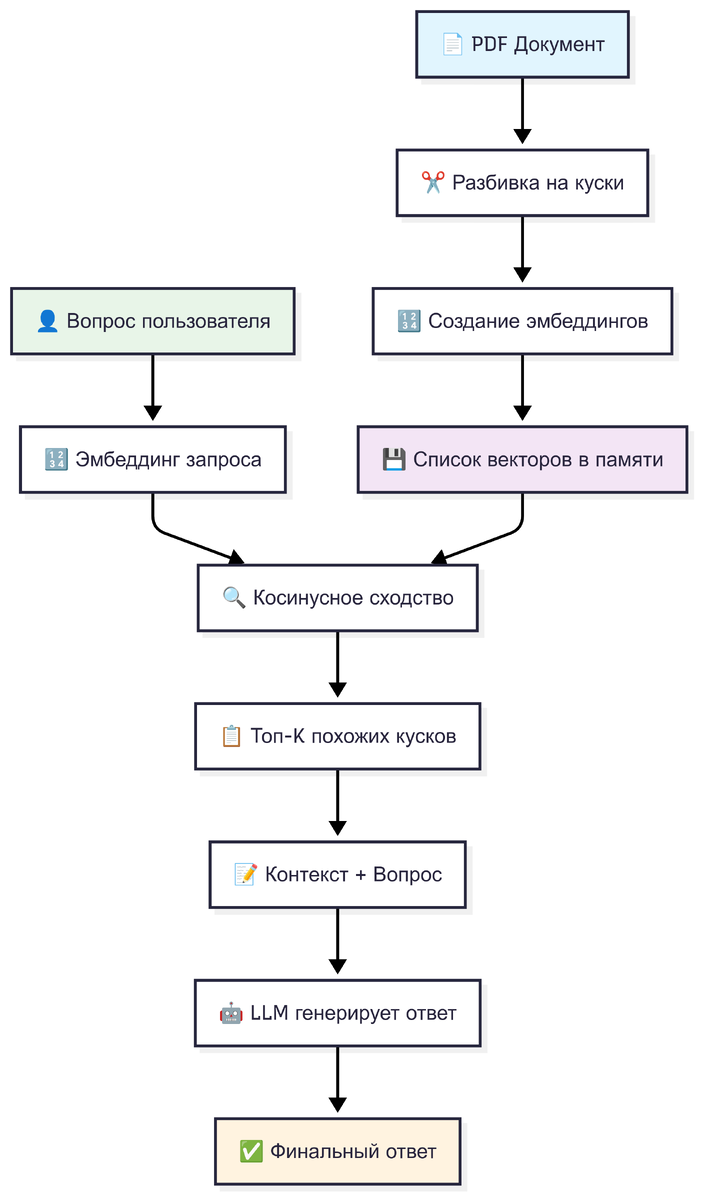

## 🛠 Шаг 1: Настройка окружения и импорт библиотек

Для работы конвейера необходимы следующие инструменты:

| Библиотека | Назначение | Причина использования |
| :--- | :--- | :--- |
| `openai` | API-клиент | Взаимодействие с сервисами Nebius AI для создания эмбеддингов и генерации текста. |
| `pymupdf` (`fitz`) | PDF-парсер | Эффективное и точное извлечение чистого текста из сложных PDF-структур. |
| `numpy` | Линейная алгебра | Вычисление метрик сходства (косинусного расстояния) между векторами. |

In [ ]:
# Установка зависимостей
!pip install openai pymupdf numpy

# Импорт необходимых модулей
import fitz  # Главный модуль PyMuPDF
import os
import numpy as np
from openai import OpenAI
from google.colab import files  # Для загрузки файлов в среду Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 16.2 MB/s eta 0:00:00


## 📂 Шаг 2: Загрузка документа

Загрузим PDF-файл, который послужит нашей внешней базой знаний (корпусом).

**Инструкция:** Запустите ячейку и выберите файл на вашем устройстве.

In [ ]:
print("Начало загрузки PDF...")
uploaded = files.upload()

# Сохраняем имя файла для дальнейшей работы

#Берем первый файл
pdf_path = list(uploaded.keys())[0]

print(f"✅ Файл '{pdf_path}' успешно загружен.")

Начало загрузки PDF...


Saving instrukciya-samsung-galaxy-s23-ultra-6.pdf to instrukciya-samsung-galaxy-s23-ultra-6.pdf
✅ Файл 'instrukciya-samsung-galaxy-s23-ultra-6.pdf' успешно загружен.


## 📝 Шаг 3: Предварительная обработка данных

### 3.1 Парсинг документа

Функция `parse_pdf_document` отвечает за извлечение структурированного текста из PDF.
Мы проходим по каждой странице (`doc.load_page(page_num)`) и используем метод `page.get_text()`, который преобразует элементы PDF в чистый, пригодный для анализа текст.

In [ ]:
def parse_pdf_document(file_path):
    """Извлекает и конкатенирует текст из каждой страницы PDF.

    :param file_path: Путь к PDF файлу.
    :return: Одна строка, содержащая весь текст документа.
    """
    full_document_text = ""
    try:
        doc = fitz.open(file_path)
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            full_document_text += page.get_text()
        doc.close()
    except Exception as e:
        print(f"Ошибка при чтении PDF: {e}")
        return ""
    return full_document_text

document_text = parse_pdf_document(pdf_path)
print(f"Извлечено {len(document_text)} символов.")

Извлечено 274018 символов.


### 3.2 Чанкинг (Разбиение) по Скользящему Окну

Крупные LLM имеют ограничения на размер входного контекста. Для эффективного поиска мы должны разбить документ на управляемые фрагменты (**чанки**).

Функция `create_sliding_window_chunks` использует технику **Скользящего Окна (Sliding Window)**:

* **`max_chars` (Размер окна):** Определяет максимальную длину одного фрагмента (по умолчанию 1000 символов). Этот размер должен быть оптимизирован под возможности модели эмбеддинга и LLM.
* **`stride_overlap` (Шаг/Перекрытие):** Определяет, сколько символов из предыдущего фрагмента должно быть включено в следующий (по умолчанию 200 символов).

> **Важность Перекрытия (Overlap):** Перекрытие критически важно для сохранения **семантической непрерывности**. Если ключевое предложение или идея находятся на границе двух фрагментов, перекрытие гарантирует, что эта идея будет полностью захвачена хотя бы в одном из них, что повышает точность поиска (Retrieval).

Механизм перекрытия:
Между фрагментами есть область дублирования размером stride:
1. Фрагмент 1: [0 ... 1000] → Конец 1 в позиции 1000
2. Фрагмент 2: [800 ... 1800] → Начало 2 в позиции 800
3. Область [800 1000] (200 символов) входит в оба фрагмента → это перекрытие.

In [ ]:
def create_sliding_window_chunks(document_text, max_chars=1000, stride_overlap=200):
    """Разбивает текст на фрагменты, используя скользящее окно."""
    corpus_fragments = []
    # Шаг, на который сдвигается окно (Размер - Перекрытие)
    stride = max_chars - stride_overlap

    if stride <= 0:
        raise ValueError("Размер перекрытия должен быть меньше размера фрагмента.")

    # Создаём последовательность начальных позиций для разрезания текста с шагом stride.
    for start_index in range(0, len(document_text), stride):
        # Окно заканчивается на start_index + max_chars
        end_index = min(start_index + max_chars, len(document_text))
        fragment = document_text[start_index:end_index]
        corpus_fragments.append(fragment)

        # Если конец фрагмента совпал с концом текста, останавливаемся
        if end_index == len(document_text):
            break

    return corpus_fragments

# Применяем функцию
corpus_fragments = create_sliding_window_chunks(document_text, max_chars=1000, stride_overlap=200)
print(f"Документ разбит на {len(corpus_fragments)} фрагментов для индексации.")

Документ разбит на 343 фрагментов для индексации.


## 🧠 Шаг 4: Индексация (Векторизация)

### 4.1 Эмбеддинги и Векторное Пространство

На этом этапе текст преобразуется в **эмбеддинги** — многомерные числовые векторы (например, из 768 или 1024 чисел). Модель эмбеддинга (здесь `BAAI/bge-multilingual-gemma2`) обучена так, чтобы тексты с похожим **смыслом (семантикой)** имели векторы, близкие друг к другу в этом пространстве. Это позволяет искать по *смыслу*, а не по *совпадению ключевых слов*.

**Модель:** `BAAI/bge-multilingual-gemma2` выбрана как высокоэффективная модель, поддерживающая множество языков (включая русский), что важно для работы с русскоязычными документами и запросами.

In [ ]:
# 🔑 Установка API ключа. Получите его в Nebius Studio.
os.environ["OPENAI_API_KEY"] = "ВАШ КЛЮЧ"

# Настройка клиента для Nebius AI (совместим с OpenAI API)
client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=os.getenv("OPENAI_API_KEY")
)

def create_embeddings(text_list, model="BAAI/bge-multilingual-gemma2"):
    """Вызывает API для преобразования списка текстов в список векторов (эмбеддингов)."""
    # Вызов метода embeddings.create для получения векторов
    response = client.embeddings.create(input=text_list, model=model)
    return response.data

# Индексация: Генерация векторов для всех фрагментов корпуса
print("⏳ Генерация эмбеддингов для всего корпуса... (требует времени)")
fragment_embeddings = create_embeddings(corpus_fragments)
print(f"✅ Индексация завершена. Получено {len(fragment_embeddings)} векторов.")

⏳ Генерация эмбеддингов для всего корпуса... (требует времени)
✅ Индексация завершена. Получено 343 векторов.


## 🔍 Шаг 5: Извлечение контекста (Retrieval)

Когда пользователь задает вопрос, мы должны найти наиболее релевантные фрагменты.

### 5.1 Косинусное сходство (Cosine Similarity)

Это метрика, используемая для измерения сходства между векторами. Она рассчитывает косинус угла $\theta$ между двумя векторами $A$ и $B$:

$$\text{similarity} = \cos(\theta) = \frac{A \cdot B}{\|A\| \cdot \|B\|}$$

* Если $\text{similarity} = 1$, векторы полностью совпадают по направлению (максимальное сходство).
* Если $\text{similarity} = 0$, векторы ортогональны (независимы, нет сходства).
* Если $\text{similarity} = -1$, векторы противоположны по направлению (максимальное различие).

Векторы запроса и фрагментов с максимальным косинусным сходством будут считаться наиболее **семантически** релевантными.

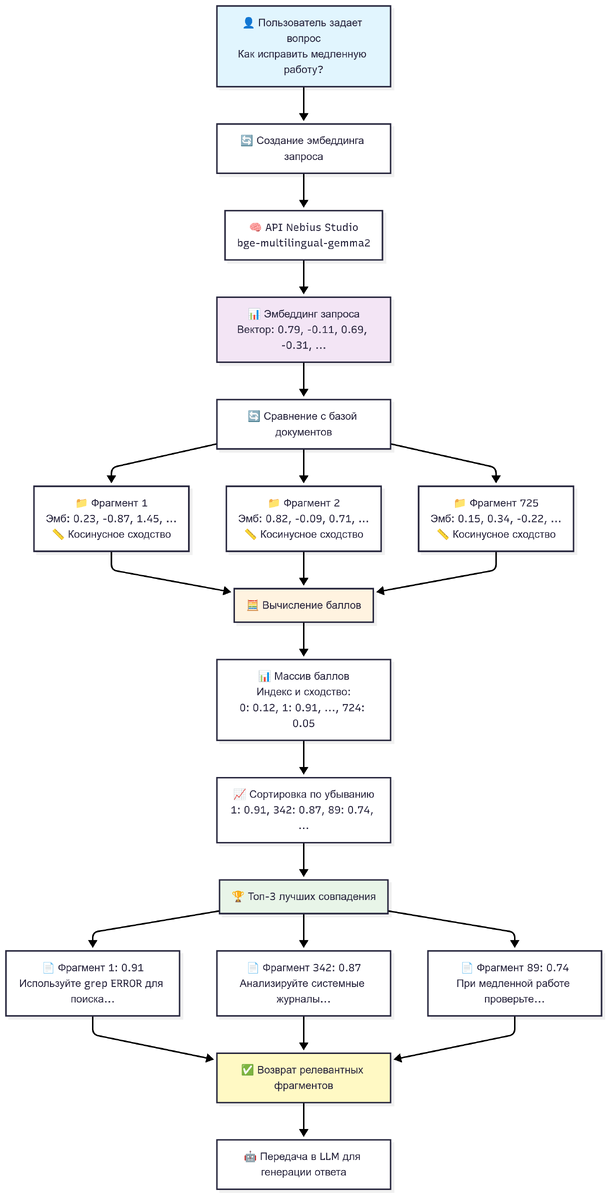

In [ ]:
def calculate_cosine_similarity(vec1, vec2):
    """Вычисляет косинусное сходство между двумя векторами NumPy."""
    # np.dot(vec1, vec2) - скалярное произведение
    # np.linalg.norm(vec) - Евклидова норма (длина) вектора
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def retrieve_context(user_query, corpus_fragments, fragment_embeddings, k_neighbors=5):
    """Находит топ-K фрагментов корпуса, наиболее близких к запросу по смыслу.

    :param k_neighbors: Количество самых релевантных фрагментов для извлечения.
    :return: Список из K фрагментов текста.
    """
    # 1. Векторизация запроса
    query_embedding_response = client.embeddings.create(
        input=[user_query],
        model="BAAI/bge-multilingual-gemma2"
    )
    # Преобразуем список чисел в вектор NumPy для расчетов
    query_embedding = np.array(query_embedding_response.data[0].embedding)

    # 2. Расчет сходства
    similarity_scores = []
    for i, emb_data in enumerate(fragment_embeddings):
        fragment_vector = np.array(emb_data.embedding)
        score = calculate_cosine_similarity(query_embedding, fragment_vector)
        similarity_scores.append((i, score))

    # 3. Сортировка и выбор топ-K
    # Сортируем по убыванию (чем выше score, тем лучше)
    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    top_k_indices = [index for index, score in similarity_scores[:k_neighbors]]

    return [corpus_fragments[i] for i in top_k_indices]

## 💬 Шаг 6: Генерация ответа (Augmented Generation)

На этом этапе LLM получает **Полный Промпт**, который состоит из трех частей:

1.  **Системная Инструкция (`system_prompt`):** Определяет роль модели (например, «Ты — ассистент по документам»). Устанавливает жесткое правило: отвечать **ТОЛЬКО** на основе предоставленного контекста.
2.  **Контекст (`context_fragments`):** Те самые $K$ релевантных фрагментов, найденных на предыдущем шаге.
3.  **Запрос Пользователя (`query`):** Оригинальный вопрос.

### Параметры Генерации

* **`model`:** Используется мощная модель, например, `Qwen/Qwen3.5-32B`.
* **`temperature=0`:** Этот параметр устанавливает минимальный уровень случайности (креативности) в ответах. Установка `0` гарантирует, что модель будет стремиться к **детерминированному, фактическому** ответу на основе предоставленного контекста, что является критически важным требованием для RAG-систем.

In [ ]:
def generate_augmented_response(query, context_fragments, model_name="Qwen/Qwen3-32B"):
    """Формирует промпт из контекста и запроса и вызывает LLM для ответа."""

    system_prompt = "Вы — экспертный ассистент по работе с документами. Ваш ответ должен быть строго основан на предоставленном КОНТЕКСТЕ. Если в КОНТЕКСТЕ нет информации для полного ответа, вы должны сообщить, что информация не найдена, не выдумывая фактов."

    # Объединяем найденные фрагменты в единый, легко читаемый контекст
    context_text = "\n\n--- РЕЛЕВАНТНЫЙ ФРАГМЕНТ ---\n\n".join(context_fragments)

    full_user_message = f"""
    КОНТЕКСТ ДЛЯ ОТВЕТА:
    {context_text}

    ВОПРОС ПОЛЬЗОВАТЕЛЯ:
    {query}
    """

    response = client.chat.completions.create(
        model=model_name,
        temperature=0, # Обеспечивает фактическую точность и снижает "галлюцинации"
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": full_user_message}
        ]
    )

    return response.choices[0].message.content

## 🚀 Шаг 7: Тестирование системы

Запустите ячейку ниже для интерактивного тестирования. Введите вопрос, и система выполнит полный цикл RAG: векторизацию запроса, поиск в корпусе и генерацию ответа LLM.

In [ ]:
# Интерактивный ввод вопроса
user_query = input("Введите ваш вопрос по загруженному документу: ")

print("\n" + "*"*40)
print("🔍 Этап 1: Извлечение контекста (Retrieval)")

# Извлекаем 3 самых релевантных фрагмента
top_k_fragments = retrieve_context(user_query, corpus_fragments, fragment_embeddings, k_neighbors=5)

# Выводим найденные фрагменты для проверки прозрачности работы
for i, chunk in enumerate(top_k_fragments):
    print(f"\n--- Найденный фрагмент {i+1} ---\n{chunk[:200]}...") # Выводим только первые 200 символов

print("\n" + "*"*40)
print("🤖 Этап 2: Генерация ответа (Augmentation)")

# Генерируем финальный ответ
final_answer = generate_augmented_response(user_query, top_k_fragments)

print("\n" + "="*60)
print("ФИНАЛЬНЫЙ ОТВЕТ СИСТЕМЫ RAG:")
print("="*60)
print(final_answer)
print("="*60)

Введите ваш вопрос по загруженному документу: Как включить камеру?

****************************************
🔍 Этап 1: Извлечение контекста (Retrieval)

--- Найденный фрагмент 1 ---

значка 
 влево на заблокированном экране.
•	 Некоторые функции камеры недоступны при открытии приложения Камера с экрана блокировки 
или при выключенном экране, если выбран способ блокировки экрана.
...

--- Найденный фрагмент 2 ---
 
съемки.
•	 Геотеги: добавление тега GPS к снимку.
•	 Сила GPS-сигнала может снизиться, если устройство используется в местах, где прием 
сигнала затруднен, например между зданиями или в низинах, а т...

--- Найденный фрагмент 3 ---
итесь переключателя 
Категории бесед, чтобы включить соответствующую функцию.
Удаление сообщений
Коснитесь сообщения, которое нужно удалить, и удерживая его выберите пункт Удалить.
Изменение настроек ...

--- Найденный фрагмент 4 ---
23 Ultra)
Делайте четкие снимки объектов крупным планом.
1	
На экране предварительного просмотра выберите пункт 1x.
